## Migration from chaotic tides

This notebook includes the effects of dynamical tides to high-eccentricity migration. In particular, for near-unity eccentricities, vibrational modes within orbiting bodies, known as dynamical tides, lead to chaotic dissipation of orbital energy and rapid inward migration.

In this example, we consider the case of a migrating warm Jupiter, as in [Liveoak et al. (2025)](https://iopscience.iop.org/article/10.3847/1538-4357/adefe7/meta) and [Vick et al. (2019).](https://academic.oup.com/mnras/article/484/4/5645/5306464)

In [1]:
# Example of chaotic migration using dynamical tides operator
import rebound
import reboundx
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 14})

In [2]:
# intial conditions
a0 = 1.5
e0 = 0.987
R_planet = 1.6 * 4.67e-4 # 1.6 Jupiter radii
m_planet = 1e-3 # approximately 1 Jupiter mass

# create simulation
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=m_planet, r=R_planet, a=a0, e=e0)
sim.move_to_com()

Here, we add the dynamical tides effect. We initialize the mode to have zero amplitude via `td_c_real` and `td_c_imag`, and set `td_dP_crit` so that mode evolution occurs even when it is not expected to be chaotic.

For detailed studies of tidal dynamics, we recommend including additional relevant short-range forces (such as `gr` and `tides_constant_time_lag`), but we omit them here for clarity.

In [3]:
# load reboundx and the dynamical tides operator
rebx = reboundx.Extras(sim)
td = rebx.load_force('tides_dynamical')
rebx.add_force(td)

sim.particles[1].params['td_c_real'] = 0
sim.particles[1].params['td_c_imag'] = 0
sim.particles[1].params['td_dP_crit'] = -1

sim.integrator = "ias15"

In [4]:
N = 1000
t = np.linspace(0, 2.5e3, N) # time
a = np.zeros(N) # semi-major axis
e = np.zeros(N) # eccentricity
E = np.zeros(N) # mode energy
E_sim = np.zeros(N) # simulation energy
L = np.zeros((N, 3)) # total angular momentum
c_imag = np.zeros(N)
c_real = np.zeros(N)

# record initial orbital energy
o = sim.particles[1].orbit(primary=sim.particles[0])
EB0 = -sim.G * sim.particles[1].m * sim.particles[0].m / (2 * o.a)

for i, time in enumerate(t):
    o = sim.particles[1].orbit(primary=sim.particles[0])
    a[i] = o.a
    e[i] = o.e
    L[i, :] = sim.angular_momentum() 
    E[i] = abs(EB0) * (sim.particles[1].params['td_c_imag']**2 + sim.particles[1].params['td_c_real']**2)
    E_sim[i] = sim.energy()
    c_imag[i] = sim.particles[1].params['td_c_imag']
    c_real[i] = sim.particles[1].params['td_c_real']

    if i % 100 == 0 and i != 0:
        print(time, o.a, o.e, E[i], sim.particles[1].params['td_dE_last'])
    
    sim.integrate(2 * np.pi * time)

250.25025025025025 0.9584227279449092 0.9796585837614492 4.650240953388716e-05 5.556436788518606e-07
500.5005005005005 1.0337935653546544 0.9811407679197943 1.6653531640065787e-05 5.548222163815767e-07
750.7507507507507 0.8008956591838183 0.9756606255391809 2.693959226977827e-05 5.577203952040341e-07
1001.001001001001 0.6345093923951877 0.9692841777206342 4.98746026933633e-05 5.608778553563783e-07
1251.2512512512512 0.3173179638311048 0.9386402522060333 1.8177093401860813e-05 5.775418288219547e-07
1501.5015015015015 0.23598964439930276 0.9175516502535422 6.715826411691418e-07 5.893434845548262e-07
1751.7517517517517 0.23595607092999615 0.9175399514581691 9.691959408449732e-07 5.893434694623728e-07
2002.002002002002 0.235973655563356 0.9175460793004557 8.113762713712163e-07 5.89338462224164e-07
2252.252252252252 0.2359736837985782 0.9175460891390531 8.098244890249597e-07 5.893423476822075e-07


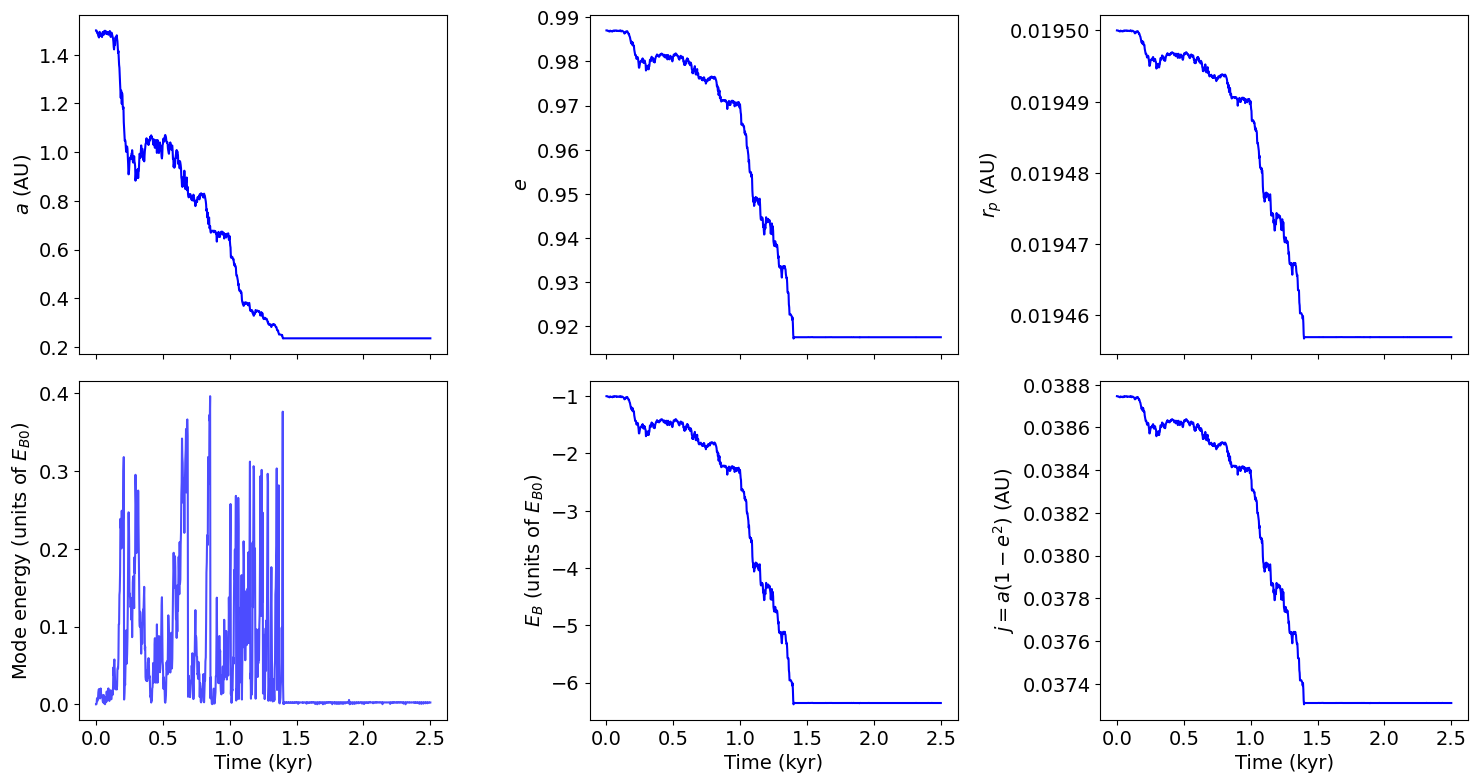

In [5]:
fig, axes = plt.subplots(2, 3, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(15)


axes[0, 0].plot(t / 1e3, a, c='blue')
axes[0, 0].set_ylabel(r'$a$ (AU)')

axes[0, 1].plot(t / 1e3, e, c='blue')
axes[0, 1].set_ylabel(r'$e$')

axes[1, 0].plot(t / 1e3, -E / EB0, alpha=0.7, c='blue')
axes[1, 0].set_ylabel(r'Mode energy (units of $E_{B0}$)')
axes[1, 0].set_xlabel(r'Time (kyr)')

axes[1, 1].plot(t / 1e3, -E_sim / EB0, c='blue')
axes[1, 1].set_ylabel(r'$E_B$ (units of $E_{B0}$)')
axes[1, 1].set_xlabel(r'Time (kyr)')

axes[0, 2].plot(t / 1e3, a * (1-e), c='blue')
axes[0, 2].set_ylabel(r'$r_p$ (AU)')

axes[1, 2].plot(t / 1e3, a * (1-e**2), c='blue')
axes[1, 2].set_ylabel(r'$j = a(1-e^2)$ (AU)')
axes[1, 2].set_xlabel(r'Time (kyr)')

plt.tight_layout()
